## Assignment 4 Group no. 7

### Project members
Linn Karlsson, linn.karlsson@aces.su.se

### Short description of notebook
This notebook contains functions for inductive conformal prediction, which I apply to both the baseline model and the tuned model from the other notebook. I also compare Mondrian/non-Mondrian approach. Then I use the tuned, Mondrian model to investigate what happens when different subclasses of particles are removed from training and calibration. I look at efficiencies, error distributions and fuzziness. I also look quickly at clustering the data to try to make sense of the observations. Finally I apply the model to data collected with another instrument.

## Import packages

In [1]:
import numpy as np
import glob
import pandas as pd
pd.options.mode.use_inf_as_na = True
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, roc_auc_score
from scipy.stats import wilcoxon
import scipy.cluster.hierarchy as shc

## Read and preprocess data 

### Read data

In [2]:
def read_MBS(path, redo_subtraction=True):
    # List of data files
    flist = glob.glob(path+'*.csv')
    flist.sort()
    
    # Empty list to hold files
    data = []
    # Shape columns, needed for background addition and subtraction
    shape = ['CA1_{}'.format(i) for i in range(512)] + ['CA2_{}'.format(i) for i in range(512)]

    for i, f in enumerate(flist):
        df = pd.read_csv(f, skiprows=30)
        # Pick out aerosol type from file name and add label
        df['label'] = f.split('_')[1]
        if redo_subtraction:
            # Reinsert the background subtraction made by the instrument
            df.loc[df['FT'] == 0, shape] = df.loc[df['FT'] == 0, shape] + np.floor(np.mean(df.loc[df['FT'] == 1, shape]))
        # Append to list
        data.append(df)

    # Combine dataframes
    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    
    # Drop non-feature columns and unused columns
    data.drop(columns=['Time(ms)', 'LASER', 'MPC', 'Total', 'Measured', 'FlrRatio'], inplace=True)
    
    return data

In [3]:
data = read_MBS('./data/', redo_subtraction=False)

#### Pick out non-background data and make some column groups

In [4]:
# Drop forced trigger measurements (blanks)
data = data[data.FT == 0]
data.drop(columns=['FT'], inplace=True)

shape = ['CA1_{}'.format(i) for i in range(512)] + ['CA2_{}'.format(i) for i in range(512)]
fluor = ['XE1_{}'.format(i+1) for i in range(8)]
other = ['Size', 'TOF', 'label']
stats = data.columns.drop(shape+fluor+other)

I made the decision, based on the exploratory pre-processing and the intended use for the developed classifier, to use the calculated shape statistics and not the full shape spectra. Hence, I drop the shape columns below.

In [5]:
# Separate data from labels
labels = data['label']
data = data.drop(columns=['label']+list(shape))

#### Broad class labels used by Ruske et al. (2017)

Non-biological: 1%NaCl, Fuller's earth dust, Phosphate buffered saline (pbs) <br>
Pollen: Paper mulberry, Poplar, Aspen <br>
Bacteria: Unwashed E. coli., Unwashed BG spores, Washed BG spores <br>
Fungal spores: Puffball

In [6]:
# Broad class labels used by Ruske et al. (2017)
broad_classes = {'1%nacl': 'non-bio', 'fullersearth': 'non-bio', 'pbs': 'non-bio', 'puffball': 'fungal',
                 'unwashedEcoli': 'bacteria', 'unwashedBGspores': 'bacteria', 'washedBGspores': 'bacteria',
                 'papermulberry': 'pollen', 'poplarpollen': 'pollen', 'aspenpollen': 'pollen'}

In [7]:
overview = pd.DataFrame(index=np.sort(labels.unique()), columns=['Parent class', 'Number of samples',
                                                        '% of total samples'])
overview['Parent class'] = pd.Series(broad_classes)
overview['Number of samples'] = labels.value_counts()
overview['% of total samples'] = (100*labels.value_counts(normalize=True)).round(2)

In [8]:
display(overview.sort_values(by='Number of samples'))

,Parent class,Number of samples,% of total samples
aspenpollen,pollen,466,2.46
poplarpollen,pollen,469,2.47
papermulberry,pollen,1048,5.53
pbs,non-bio,1388,7.32
washedBGspores,bacteria,1417,7.47
unwashedBGspores,bacteria,1831,9.66
unwashedEcoli,bacteria,1991,10.50
puffball,fungal,2607,13.75
fullersearth,non-bio,3238,17.08
1%nacl,non-bio,4502,23.75


### Divide data into training, test, and calibration sets

#### Split data into training, calibration, and test sets
50% training <br>
25% calibration <br>
25% test

In [7]:
# First split into training (50% of total data) and test (25% of total data) sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels,
                                                                    test_size=0.25,
                                                                    train_size=0.5,
                                                                    stratify=labels,
                                                                    shuffle=True,
                                                                    random_state=0)
# The above used only 75% of the data.
# The remaining 25% is also stratified and will be used as the calibration set.
idx_cal = data.index ^ data_train.index ^ data_test.index
idx_cal = np.random.permutation(idx_cal)
data_cal, labels_cal = data.loc[idx_cal], labels.loc[idx_cal]

## Inductive conformal prediction

### Functions to use on sklearn output

In [8]:
def differenceerror(prediction, comparison=None):
    '''Conformity function.
    Input:
        prediction : dataframe with class probabilities (class labels as columns)
        comparison : series with true class labels (for calibration, otherwise all classes are compared)
    Output:
        differences : dataframe with conformity scores (-1 to 0) (predicted class probability - 1)
                      where a lower score means the sample is more NON-conforming.
    '''
    if comparison is None:
        differences = prediction.copy()
        differences[:] = 0.
        # Compare to all possible classes
        for c, col in prediction.iteritems():
            differences[c] = prediction[c] - 1
    else:
        differences = np.zeros(comparison.size)
        # Compare to comparison (should be true class labels for calibration)
        for i, c in enumerate(comparison):
            differences[i] =  prediction.loc[i, c] - 1
    
    return differences


def marginerror(prediction, comparison=None):
    '''Conformity function.
    Input:
        prediction : dataframe with class probabilities (class labels as columns)
        comparison : series with true class labels (for calibration, otherwise all classes are compared)
    Output:
        margins : dataframe with conformity scores (from -1 to 1) (predicted class prob. - higest other prob.)
                  where a lower score means the sample is more NON-conforming.
    '''
    if comparison is None:
        margins = prediction.copy()
        margins[:] = 0.
        # Compare to all possible classes
        for c, col in prediction.iteritems():
            margins[c] = col - prediction.drop(columns=c).max(axis=1)
    else:
        margins = np.zeros(comparison.size)
        # Compare to comparison (should be true class labels for calibration)
        for i, c in enumerate(comparison):
            margins[i] = prediction.loc[i, c] - prediction.drop(columns=c).max(axis=1).loc[i]
    
    return margins


def pvalue(model, testdata, caldata, caltarget, nc_score='difference', mondrian=False):
    '''Calculates p-values based on the conformity scores of test data and calibration data.
    Input:
        model : an sklearn predictive model (e.g. GradientBoostingClassifier)
        testdata : dataframe with test data
        caldata : dataframe with calibration data
        caltarget : series with true class labels of calibration data
        nc_score : which non-conformity score to use, either 'margin' or 'difference' (default)
        mondrian : use separate calibration sets for each class (True) or not (False)
    Output:
        test_prediction : predicted probabilities of underlying model on test set
        pvalues : dataframe with p-values for each class for each test instance'''
    
    cal_prediction = pd.DataFrame(model.predict_proba(caldata), columns=model.classes_)
    test_prediction = pd.DataFrame(model.predict_proba(testdata), columns=model.classes_)
    
    if nc_score == 'margin':
        calibration = marginerror(cal_prediction, caltarget)
        scores = marginerror(test_prediction)
    elif nc_score == 'difference':
        calibration = differenceerror(cal_prediction, caltarget)
        scores = differenceerror(test_prediction)
    
    pvalues = scores.copy()
    pvalues[:] = 0
    
    groups = pd.Series(calibration, index=caltarget.index).groupby(caltarget)
    
    for i, row in scores.iterrows():
        if mondrian:
            n = np.array([np.sum(groups.get_group(x) <= row.loc[x]) for x in row.index])
            pvalues.loc[i] = n / (groups.apply(len)).values
        else:
            n = np.array([np.sum(calibration <= value) for value in row])
            pvalues.loc[i] = n / (len(calibration))
    
    return test_prediction, pvalues


def evaluate_icp(pvalues, true_labels, sigma=np.round(np.linspace(0, 0.3, 40), 4),
                 detailed_labels=None, removed_class=None):
    '''Calculate characteristics of the conformal predictor.
    Input:
        pvalues : output from the pvalues function
        true_labels : the true class labels of the samples
        sigma : the significance level(s) at which to evaluate the conformal predictor
        OPTIONAL (if subclass labels are needed to consider some empty predictions correct)
            detailed_labels : like true_labels, but with subclasses instead
            removed_class : specify which subclass was removed if detailed_labels are to be used for error calculation
    Output:
        output : a dataframe with error and efficiency metrics for the conformal predictor at given sigma
    '''
    if type(sigma) in [float, int]:
        sigma = [sigma]
    
    output = pd.DataFrame(index=sigma, columns=['Error', 'OneAcc', 'OneC',
                                                'MultiC', 'ZeroC', 'AvgC'],
                          dtype=float)
    for s in sigma:
        # The output set at significance s
        sets = pvalues.apply(lambda row: pvalues.columns[row > s], axis=1)
        # The error = proportion of sets that do not contain true label
        output.loc[s, 'Error'] = sum([c not in sets.iloc[i] for i, c in enumerate(true_labels)]) / len(true_labels)
        
        if (detailed_labels is not None) and (removed_class is not None):
            # Reindex subclasses
            subclasses = detailed_labels.reset_index(drop=True)
            # Find correct zero sets
            rejections = sets[sets.apply(len) == 0].index & subclasses[subclasses == removed_class].index
            # Calculcate proportion that should count as "correctly classified" and remove from error
            output.loc[s, 'Error'] -= len(rejections) / len(true_labels)
        
        # Find the sets that contain only one class and calculate their accuracy
        idx = sets[sets.apply(len) == 1].index
        oneclasses = (sets.iloc[idx] == true_labels.reset_index(drop=True).iloc[idx])
        output.loc[s, 'OneAcc'] = (oneclasses.sum() / len(oneclasses))
        
        # Count number of classes in output sets
        sets = (pvalues.where(pvalues > s).notna().sum(axis=1).value_counts())
        #print(sets)
        output.loc[s, 'AvgC'] = np.sum(sets.values * sets.index.values) / np.sum(sets.values)
        # What proportion belong to ZeroC, OneC, MultiC...
        output.loc[s, ['ZeroC', 'OneC', 'MultiC']] = np.array([sets[0] if 0 in sets.index else np.nan,
                                                   sets[1] if 1 in sets.index else np.nan,
                                                   sets.drop(index=[0,1], errors='ignore').sum()]) / len(true_labels)
    
    return output


def icp_plot(output, axis=None):
    '''Plot the characteristics of the conformal predictor, like figures from Johansson et al. (2013).
    '''
    linestyles = ['-', '-', '-', '--', ':']
    colours = ['r', 'g', 'k', 'k', 'k']
    
    if axis is None:
        # Make a figure
        plt.figure()
        output.drop(columns='AvgC').plot(style=linestyles, color=colours, ax=plt.gca())
        plt.xlabel('Significance')
        plt.ylim(0, 1)
        plt.gca().yaxis.set_ticks_position('both')
        plt.show()
    else:
        # Put the plot in existing axes
        output.drop(columns='AvgC').plot(style=linestyles, color=colours, ax=axis)
        axis.set_xlabel('Significance')
        axis.set_ylim(0, 1)
        axis.yaxis.set_ticks_position('both')
        plt.draw()


### Run model and apply conformal prediction

#### Compare baseline/tuned and Mondrian/non-Mondrian

##### Baseline model

In [11]:
model = GradientBoostingClassifier(random_state=0)

model.fit(data_train, labels_train.replace(broad_classes))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

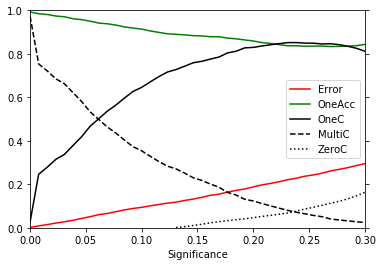

In [12]:
# Mondrian
predictions, pvalues = pvalue(model, data_test, data_cal, labels_cal.replace(broad_classes),
                              nc_score='difference', mondrian=True)

baseline = evaluate_icp(pvalues, true_labels=labels_test.replace(broad_classes))
icp_plot(baseline)

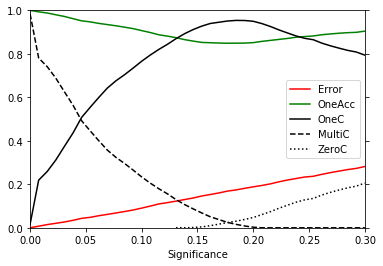

In [13]:
# Non-Mondrian
predictions, pvalues = pvalue(model, data_test, data_cal, labels_cal.replace(broad_classes),
                              nc_score='difference', mondrian=False)

baseline_nonmon = evaluate_icp(pvalues, true_labels=labels_test.replace(broad_classes))
icp_plot(baseline_nonmon)

##### Tuned model

In [14]:
args = {'min_samples_split': 60, 'min_samples_leaf': 4,
            'max_depth': 9, 'max_features': 'sqrt',
            'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.1}

model = GradientBoostingClassifier(random_state=0, **args)

model.fit(data_train, labels_train.replace(broad_classes))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=60,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

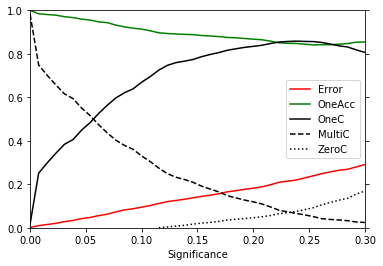

In [15]:
# Mondrian
predictions, pvalues = pvalue(model, data_test, data_cal, labels_cal.replace(broad_classes),
                              nc_score='difference', mondrian=True)

tuned = evaluate_icp(pvalues, true_labels=labels_test.replace(broad_classes))
tuned_allsigma = evaluate_icp(pvalues, true_labels=labels_test.replace(broad_classes),
                              sigma=np.linspace(0, 0.99, 30))

icp_plot(tuned)

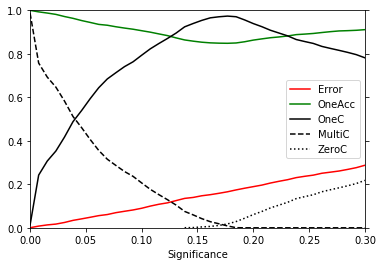

In [16]:
# Non-Mondrian
predictions, pvalues = pvalue(model, data_test, data_cal, labels_cal.replace(broad_classes),
                              nc_score='difference', mondrian=False)

tuned_nonmon = evaluate_icp(pvalues, true_labels=labels_test.replace(broad_classes))
tuned_nonmon_allsigma = evaluate_icp(pvalues, true_labels=labels_test.replace(broad_classes),
                                     sigma=np.linspace(0, 0.99, 30))
icp_plot(tuned_nonmon)

##### Compare efficiency (average number of classes in output set)

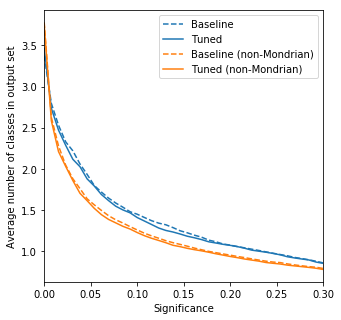

In [17]:
plt.figure(figsize=(5, 5))
baseline['AvgC'].plot(label='Baseline', style='--', c='C0')
tuned['AvgC'].plot(label='Tuned', style='-', c='C0')

baseline_nonmon['AvgC'].plot(label='Baseline (non-Mondrian)', style='--', c='C1')
tuned_nonmon['AvgC'].plot(label='Tuned (non-Mondrian)', style='-', c='C1')

plt.ylabel('Average number of classes in output set')
plt.xlabel('Significance')
plt.legend()
plt.show()

* The tuned model is marginally more efficient than the baseline model
* Non-Mondrian seems more efficient, but how does it behave for individual classes?

#### Compare Mondrian/non-Mondrian class-wise

In [18]:
parentclass = labels_test.replace(broad_classes)

In [19]:
# # Evaluate each parent class with Mondrian and non-Mondrian

effs = {}

for parent in parentclass.unique():
    predictions, pvalues = pvalue(model, data_test[parentclass==parent], data_cal,
                                  labels_cal.replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    effs[parent] = evaluate_icp(pvalues, true_labels=parentclass[parentclass==parent],
                                sigma=np.linspace(0, 0.99, 30))

    predictions, pvalues = pvalue(model, data_test[parentclass==parent], data_cal,
                                   labels_cal.replace(broad_classes),
                                   nc_score='difference', mondrian=False)
    effs[parent+'_nm'] = evaluate_icp(pvalues, true_labels=parentclass[parentclass==parent],
                                      sigma=np.linspace(0, 0.99, 30))

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


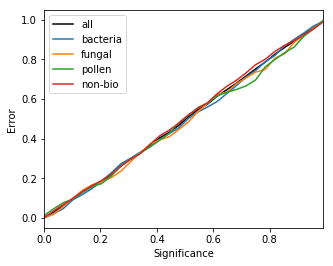

In [20]:
# Summary figure: Mondrian
plt.figure(figsize=(5, 4))
tuned_allsigma['Error'].plot(label='all', c='k')
effs['bacteria']['Error'].plot(label='bacteria')
effs['fungal']['Error'].plot(label='fungal')
effs['pollen']['Error'].plot(label='pollen')
effs['non-bio']['Error'].plot(label='non-bio')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Significance')
plt.show()

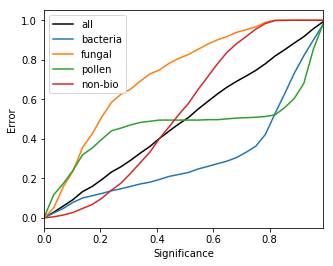

In [21]:
# Summary figure: non-Mondrian
plt.figure(figsize=(5, 4))
tuned_nonmon_allsigma['Error'].plot(label='all', c='k')
effs['bacteria_nm']['Error'].plot(label='bacteria')
effs['fungal_nm']['Error'].plot(label='fungal')
effs['pollen_nm']['Error'].plot(label='pollen')
effs['non-bio_nm']['Error'].plot(label='non-bio')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Significance')
plt.show()

* Looking only at the full dataset, the non-Mondrian approach seems to give a more efficient conformal predictor. However, the error level cannot be guaranteed for individual classes, and for fungal spores the predictor is just not very good at all at any significance level. Probably the non-Mondrian is only more efficient (with respect to AvgC) because the samples that are easier to classify (non-bio and bacteria) are given more weight because of the imbalance in the dataset.

&rarr; I will use the Mondrian approach.

### Predicting unknown particles

#### Overview plots 

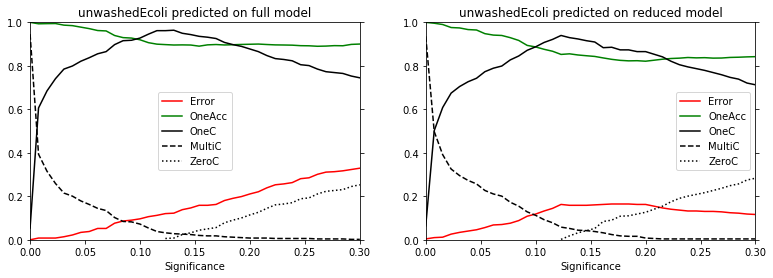

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


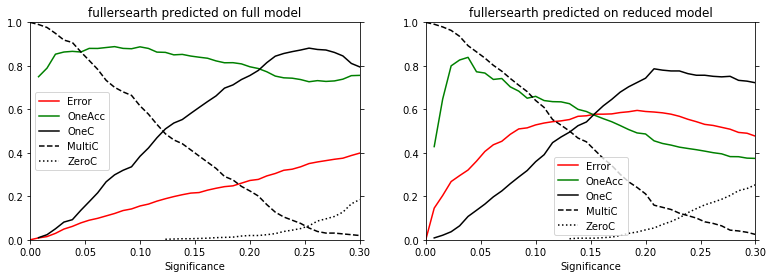

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


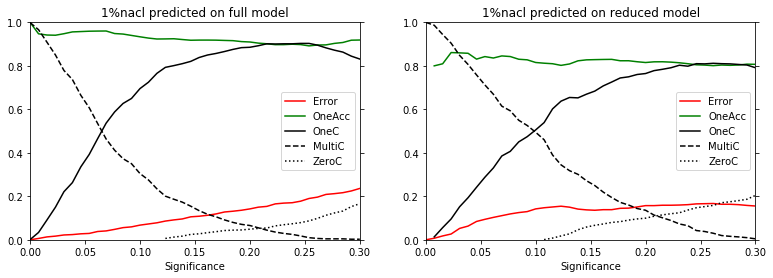

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


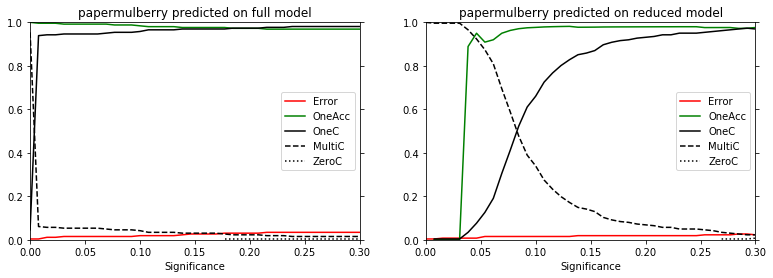

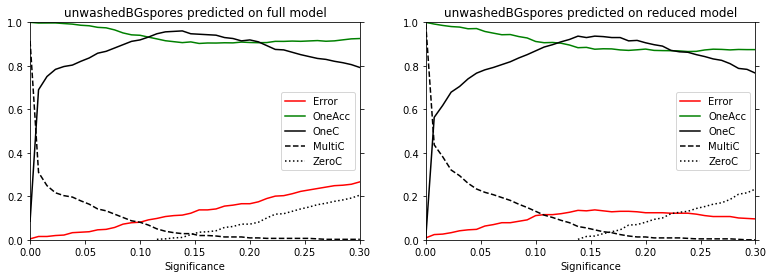

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


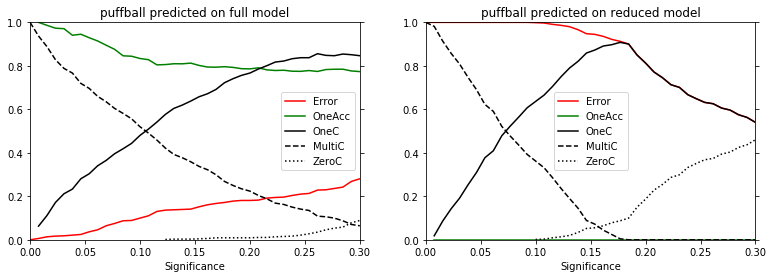

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


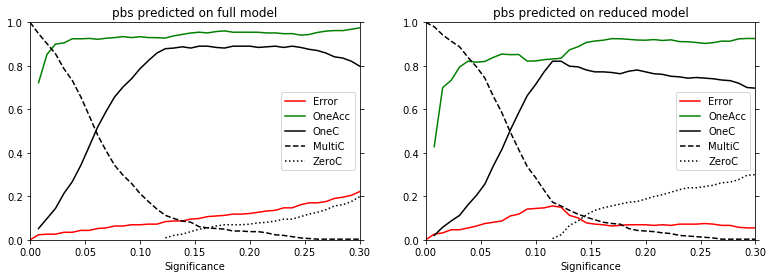

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


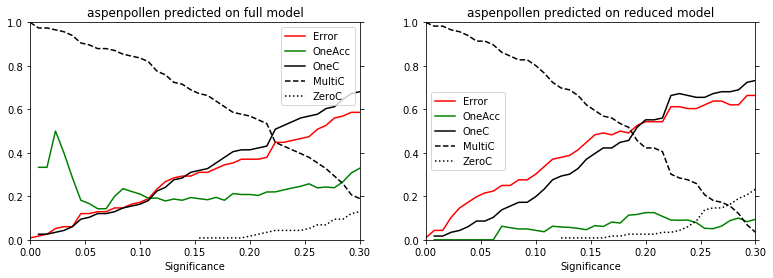

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


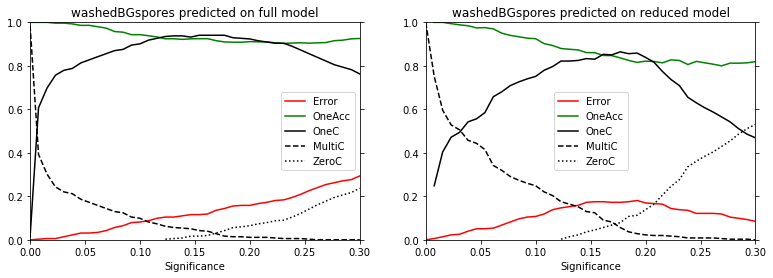

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


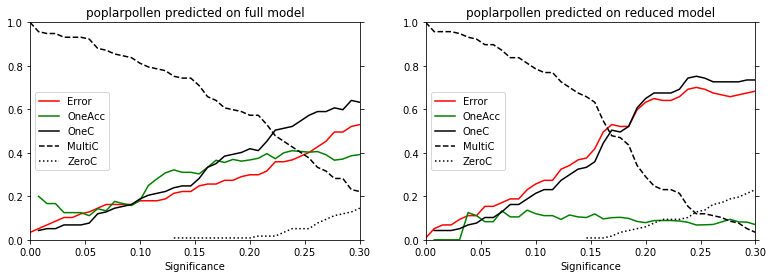

In [22]:
# ICP overview plots
model = GradientBoostingClassifier(random_state=0, **args)

for subclass in labels_test.unique():
    fig, ax = plt.subplots(ncols=2, figsize=(13, 4))
    # Without subclass removed
    ax[0].set_title(subclass+' predicted on full model')
    ax[0].yaxis.set_ticks_position('both')
    
    model.fit(data_train, labels_train.replace(broad_classes))

    predictions, pvalues = pvalue(model, data_test[labels_test==subclass], data_cal,
                                  labels_cal.replace(broad_classes),
                                  nc_score='difference', mondrian=True)

    output = evaluate_icp(pvalues, true_labels=labels_test[labels_test==subclass].replace(broad_classes))
    icp_plot(output, axis=ax[0])
    
    # With subclass removed
    ax[1].set_title(subclass+' predicted on reduced model')
    ax[1].yaxis.set_ticks_position('both')
    
    model.fit(data_train[labels_train!=subclass],
              labels_train[labels_train!=subclass].replace(broad_classes))

    predictions, pvalues = pvalue(model, data_test[labels_test==subclass], data_cal[labels_cal!=subclass],
                                  labels_cal[labels_cal!=subclass].replace(broad_classes),
                                  nc_score='difference', mondrian=True)

    output = evaluate_icp(pvalues,
                          true_labels=labels_test[labels_test==subclass].replace(broad_classes),
                          detailed_labels=labels_test[labels_test==subclass],
                          removed_class=subclass)
    icp_plot(output, axis=ax[1])
    
    plt.show()

* The overview plots show that there are some clear differences when the particles are not included in training and calibration, but it is hard to quantify. I will look at the scores for the individual classes at one significance level and see how they differ. I pick 0.2 because ZeroC is present but OneC is also close to max in most cases, and 80% confidence is still meaningful

#### Error, OneAcc, etc evaluated at sigma=0.2

In [26]:
#Below are functions to style displayed dataframes, but unfortunately the styling 
#seems to go away when the kernel isn't running so it probably won't show up for you.

def highlight_max(s):
    '''
    Highlight the maximum in a Series yellow.
    Code from: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    Code from: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color


def highlight_true(s):
    '''
    Highlight the true parent class in each column
    '''
    
    is_true = s.index == broad_classes[s.name]
    return ['background-color: lime' if v else '' for v in is_true]
    

def bold_high(val):
    '''
    Bold values where abs(v) > 0.1
    '''
    weight = 'bold' if np.abs(val) > 0.1 else 'normal'
    return 'font-weight: %s' %weight
    

##### Evaluated for each subclass when it is unknown

In [27]:
# Error distribution for each subclass, when it is NOT included in the model training
output_a = []

for subclass in tqdm(labels_test.unique()):
    parent = broad_classes[subclass]
    
    model.fit(data_train[labels_train!=subclass],
              labels_train[labels_train!=subclass].replace(broad_classes))

    predictions, pvalues = pvalue(model, data_test[labels_test==subclass],
                                  data_cal[labels_cal!=subclass],
                                  labels_cal[labels_cal!=subclass].replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    
    # Evaluate at sigma=0.2
    out = evaluate_icp(pvalues, parentclass[labels_test==subclass],
                       detailed_labels=labels_test[labels_test==subclass],
                       removed_class=subclass, sigma=0.2)
    out.index = [subclass]
    output_a.append(out)


pd.concat(output_a).round(2)

100%|██████████| 10/10 [00:46<00:00,  4.30s/it]


,Error,OneAcc,OneC,MultiC,ZeroC,AvgC
unwashedEcoli,0.16,0.82,0.87,0.01,0.13,0.88
fullersearth,0.59,0.49,0.74,0.21,0.05,1.17
1%nacl,0.16,0.82,0.76,0.14,0.10,1.04
papermulberry,0.02,0.98,0.93,0.07,NaN,1.07
unwashedBGspores,0.12,0.88,0.91,0.01,0.08,0.93
puffball,0.81,0.00,0.81,0.00,0.19,0.81
pbs,0.07,0.92,0.77,0.04,0.19,0.85
aspenpollen,0.54,0.12,0.55,0.42,0.03,1.40
washedBGspores,0.17,0.82,0.84,0.02,0.14,0.88
poplarpollen,0.63,0.08,0.65,0.29,0.06,1.23


##### Evaluated for each subclass when it is known

In [28]:
# Error distribution for each subclass, when it IS included in the model training
output_b = []

for subclass in tqdm(labels_test.unique()):
    parent = broad_classes[subclass]
    
    model.fit(data_train,
              labels_train.replace(broad_classes))

    predictions, pvalues = pvalue(model, data_test[labels_test==subclass],
                                  data_cal,
                                  labels_cal.replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    
    # Evaluate at sigma=0.2
    out = evaluate_icp(pvalues, parentclass[labels_test==subclass], sigma=0.2)
    out.index = [subclass]
    output_b.append(out)


pd.concat(output_b).round(2)

100%|██████████| 10/10 [00:50<00:00,  4.63s/it]


,Error,OneAcc,OneC,MultiC,ZeroC,AvgC
unwashedEcoli,0.21,0.90,0.88,0.01,0.11,0.89
fullersearth,0.27,0.80,0.76,0.22,0.02,1.21
1%nacl,0.14,0.91,0.89,0.07,0.05,1.02
papermulberry,0.03,0.97,0.97,0.02,0.00,1.02
unwashedBGspores,0.17,0.91,0.92,0.01,0.07,0.94
puffball,0.18,0.79,0.77,0.22,0.01,1.21
pbs,0.12,0.95,0.89,0.04,0.07,0.97
aspenpollen,0.37,0.21,0.41,0.57,0.02,1.55
washedBGspores,0.16,0.91,0.92,0.01,0.06,0.95
poplarpollen,0.30,0.37,0.42,0.57,0.01,1.56


##### Difference between the subclass being unknown and being known

In [29]:
(pd.concat(output_a) - pd.concat(output_b)).round(3).style.applymap(color_negative_red).applymap(bold_high)

,Error,OneAcc,OneC,MultiC,ZeroC,AvgC
unwashedEcoli,-0.048,-0.078,-0.012,0,0.012,-0.012
fullersearth,0.317,-0.309,-0.012,-0.014,0.026,-0.043
1%nacl,0.015,-0.094,-0.121,0.07,0.051,0.022
papermulberry,-0.011,0.007,-0.042,0.046,nan,0.05
unwashedBGspores,-0.041,-0.03,-0.013,0.004,0.009,-0.004
puffball,0.632,-0.786,0.046,-0.224,0.178,-0.402
pbs,-0.052,-0.037,-0.118,0.003,0.115,-0.112
aspenpollen,0.172,-0.083,0.138,-0.147,0.009,-0.155
washedBGspores,0.011,-0.09,-0.085,0.011,0.073,-0.062
poplarpollen,0.333,-0.288,0.231,-0.282,0.051,-0.333


#### Look at error distribution

##### Without conformal prediction

Sort of confusion matrices, but with subclass resolution just ot see what they are confused with when they're unknown (and what they're confused with even when they're not unknown!)

In [30]:
# Distribution for each subclass, when it is NOT included in the model training
output = pd.DataFrame(np.nan, columns=labels_test.unique(), index=parentclass.unique())

for subclass in tqdm(labels_test.unique()):
    model.fit(data_train[labels_train!=subclass],
              labels_train[labels_train!=subclass].replace(broad_classes))

    output[subclass] = pd.Series(model.predict(data_test[labels_test==subclass])).value_counts(normalize=True)

output.round(2).style.apply(highlight_max).apply(highlight_true)

100%|██████████| 10/10 [00:33<00:00,  3.51s/it]


,unwashedEcoli,fullersearth,1%nacl,papermulberry,unwashedBGspores,puffball,pbs,aspenpollen,washedBGspores,poplarpollen
bacteria,0.82,0.01,0.1,0.03,0.84,0.04,0.12,0.07,0.82,0.1
non-bio,0.17,0.5,0.8,0.03,0.15,0.82,0.87,0.55,0.17,0.41
pollen,0.01,0.13,0,0.92,0.01,0.15,0,0.08,0.01,0.14
fungal,0,0.35,0.1,0.02,0,nan,0.01,0.3,0.01,0.35


In [31]:
# Distribution for each subclass, when it IS included in the model training
output = pd.DataFrame(np.nan, columns=labels_test.unique(), index=parentclass.unique())

for subclass in tqdm(labels_test.unique()):
    model.fit(data_train,
              labels_train.replace(broad_classes))

    output[subclass] = pd.Series(model.predict(data_test[labels_test==subclass])).value_counts(normalize=True)

output.round(2).style.apply(highlight_max).apply(highlight_true)

100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


,unwashedEcoli,fullersearth,1%nacl,papermulberry,unwashedBGspores,puffball,pbs,aspenpollen,washedBGspores,poplarpollen
bacteria,0.88,0.01,0.02,0.01,0.89,0.01,0.05,0.04,0.9,0.09
non-bio,0.12,0.89,0.95,0.02,0.1,0.36,0.94,0.46,0.1,0.35
pollen,0,0.02,0.01,0.97,0,0.06,nan,0.3,0,0.32
fungal,0,0.08,0.02,0.01,0,0.56,0.01,0.2,nan,0.25


##### With conformal prediction (sigma=0.2)

How the predictions are distributed in the conformal prediction case. Added a zero type to include ZeroC, and because of multi-class outputs the sum of each column is not necessarily 1.

In [32]:
# Distribution for each subclass, when it is NOT included in the model training
output_a = pd.DataFrame(np.nan, columns=labels_test.unique(), index=list(parentclass.unique())+['zero'])

for subclass in tqdm(labels_test.unique()):
    model.fit(data_train[labels_train!=subclass],
              labels_train[labels_train!=subclass].replace(broad_classes))

    predictions, pvalues = pvalue(model, data_test[labels_test==subclass],
                                  data_cal[labels_cal!=subclass],
                                  labels_cal[labels_cal!=subclass].replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    
    output_a[subclass] = (pvalues > 0.2).sum()
    output_a.loc['zero', subclass] = np.count_nonzero((pvalues > 0.2).sum(axis=1)==0)
    
    output_a[subclass] /= len(pvalues)

output_a.round(2).style.apply(highlight_max).apply(highlight_true)

100%|██████████| 10/10 [00:44<00:00,  4.29s/it]


,unwashedEcoli,fullersearth,1%nacl,papermulberry,unwashedBGspores,puffball,pbs,aspenpollen,washedBGspores,poplarpollen
bacteria,0.71,0,0.01,0.01,0.79,0.01,0.02,0.01,0.69,0.03
non-bio,0.13,0.36,0.74,0.02,0.09,0.51,0.74,0.29,0.09,0.19
pollen,0.03,0.29,0.05,0.98,0.02,0.29,0.02,0.43,0.04,0.31
fungal,0.02,0.51,0.24,0.06,0.03,nan,0.07,0.66,0.06,0.7
zero,0.13,0.05,0.1,0,0.08,0.19,0.19,0.03,0.14,0.06


In [33]:
# Distribution for each subclass, when it IS included in the model training
output_b = pd.DataFrame(np.nan, columns=labels_test.unique(), index=list(parentclass.unique())+['zero'])

for subclass in tqdm(labels_test.unique()):
    model.fit(data_train,
              labels_train.replace(broad_classes))
    
    predictions, pvalues = pvalue(model, data_test[labels_test==subclass],
                                  data_cal,
                                  labels_cal.replace(broad_classes),
                                  nc_score='difference', mondrian=True)

    output_b[subclass] = (pvalues > 0.2).sum()
    output_b.loc['zero', subclass] = np.count_nonzero((pvalues > 0.2).sum(axis=1)==0)
    
    output_b[subclass] /= len(pvalues)

output_b.div(output_b.sum()).round(2).style.apply(highlight_max).apply(highlight_true)

100%|██████████| 10/10 [00:55<00:00,  5.25s/it]


,unwashedEcoli,fullersearth,1%nacl,papermulberry,unwashedBGspores,puffball,pbs,aspenpollen,washedBGspores,poplarpollen
bacteria,0.78,0,0.01,0,0.83,0,0.02,0.01,0.83,0.03
non-bio,0.08,0.59,0.8,0.01,0.07,0.16,0.85,0.18,0.06,0.11
pollen,0.01,0.12,0.03,0.95,0.02,0.16,0.01,0.4,0.01,0.45
fungal,0.01,0.26,0.12,0.03,0.02,0.67,0.05,0.4,0.03,0.41
zero,0.11,0.02,0.05,0,0.07,0.01,0.07,0.01,0.06,0.01


In [34]:
(output_a - output_b).round(3).style.applymap(color_negative_red).apply(highlight_true)

,unwashedEcoli,fullersearth,1%nacl,papermulberry,unwashedBGspores,puffball,pbs,aspenpollen,washedBGspores,poplarpollen
bacteria,-0.078,0,0.001,0.004,-0.039,0.005,0,-0.009,-0.15,-0.009
non-bio,0.046,-0.363,-0.115,0,0.024,0.313,-0.135,0.017,0.025,0.009
pollen,0.016,0.132,0.022,0.011,0.004,0.1,0.003,-0.198,0.031,-0.393
fungal,0.004,0.188,0.114,0.034,0.007,nan,0.02,0.034,0.031,0.06
zero,0.012,0.026,0.051,-0.004,0.009,0.178,0.115,0.009,0.073,0.051


#### Fuzziness

Look at fuzziness of predictions for the subclasses. Also use Wilcoxon test to see if the fuzziness is significantly different when the subclass is not included in training+calibration and when it is.

In [35]:
def fuzziness(pvalues, true_labels=None):
    '''Calculate the fuzziness or the observed fuzziness of predictions.
    Input:
        pvalues : the pvalues from the conformal predictor
        true_labels : (optional) true class labels, if we are interested in the OBSERVED fuzziness
    Output
        fuzziness : (observed) fuzziness of predictions'''
    if true_labels is None:
        fuzziness = pvalues.apply(lambda row: row.drop(row.idxmax()).sum(), axis=1)
    else:
        fuzziness = pd.Series([pvalues.iloc[i, :].drop(c, errors='ignore').sum() for i, c in enumerate(true_labels)],
                              index=pvalues.index)
    return fuzziness

In [36]:
full_model = GradientBoostingClassifier(random_state=0, **args)

full_model.fit(data_train, labels_train.replace(broad_classes))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=60,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [37]:
# Calculate fuzziness and compare between subclass predicted on full model and on model where it is unknown
fuzz = pd.DataFrame(index=labels_test.unique(), columns=['Full model', 'Reduced model', 'Wilcoxon'])
fuzz_obs = pd.DataFrame(index=labels_test.unique(), columns=['Full model', 'Reduced model', 'Wilcoxon'])

for subclass in tqdm(labels_test.unique()):
    predictions, pvalues = pvalue(full_model, data_test[labels_test==subclass],
                                  data_cal,
                                  labels_cal.replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    
    fuzz1 = fuzziness(pvalues)
    fuzz1_obs = fuzziness(pvalues, labels_test[labels_test==subclass].replace(broad_classes))
    
    model.fit(data_train[labels_train!=subclass],
              labels_train[labels_train!=subclass].replace(broad_classes))

    predictions, pvalues = pvalue(model, data_test[labels_test==subclass],
                                  data_cal[labels_cal!=subclass],
                                  labels_cal[labels_cal!=subclass].replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    
    fuzz2 = fuzziness(pvalues)
    fuzz2_obs = fuzziness(pvalues, labels_test[labels_test==subclass].replace(broad_classes))
    
    _, wp = wilcoxon(fuzz1, fuzz2)
    _, wp_obs = wilcoxon(fuzz1_obs, fuzz2_obs)
    
    fuzz.loc[subclass, 'Full model'] = fuzz1.mean()
    fuzz.loc[subclass, 'Reduced model'] = fuzz2.mean()
    fuzz.loc[subclass, 'Wilcoxon'] = wp
    
    fuzz_obs.loc[subclass, 'Full model'] = fuzz1_obs.mean()
    fuzz_obs.loc[subclass, 'Reduced model'] = fuzz2_obs.mean()
    fuzz_obs.loc[subclass, 'Wilcoxon'] = wp
    

100%|██████████| 10/10 [01:05<00:00,  5.56s/it]


##### "Regular" fuzziness for the different subclasses

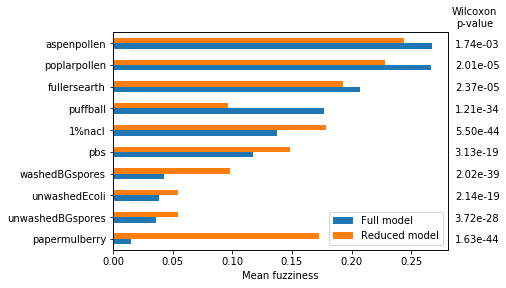

In [38]:
ax = fuzz.drop(columns='Wilcoxon').sort_values(by='Full model').plot(kind='barh')
plt.xlabel('Mean fuzziness')

y = plt.twinx()
y.set_ylim(ax.get_ylim())
y.set_yticks(ax.get_yticks())
y.set_yticklabels(fuzz.sort_values(by='Full model')['Wilcoxon'].apply(lambda x: '{:0.2e}'.format(x)))
y.tick_params(right=False)
plt.title('Wilcoxon\np-value', x=1.08, fontsize=10)

plt.show()

##### Observed fuzziness for the different subclasses

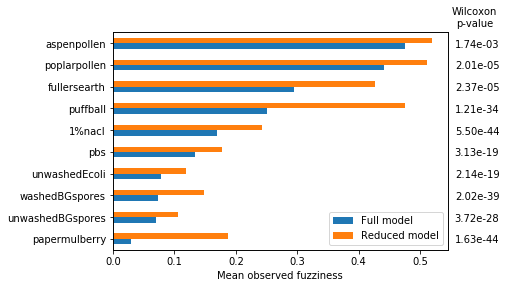

In [39]:
ax = fuzz_obs.drop(columns='Wilcoxon').sort_values(by='Full model').plot(kind='barh')
plt.xlabel('Mean observed fuzziness')

y = plt.twinx()
y.set_ylim(ax.get_ylim())
y.set_yticks(ax.get_yticks())
y.set_yticklabels(fuzz_obs.sort_values(by='Full model')['Wilcoxon'].apply(lambda x: '{:0.2e}'.format(x)))
y.tick_params(right=False)
plt.title('Wilcoxon\np-value', x=1.08, fontsize=10)

plt.show()

##### Fuzziness for the whole test set prediction (but still with different subclasses removed)

In [40]:
#
stuff = pd.DataFrame(index=labels_test.unique(), columns=['Full model', 'Reduced model', 'Wilcoxon'])

for subclass in tqdm(labels_test.unique()):
    predictions, pvalues = pvalue(full_model, data_test,
                                  data_cal,
                                  labels_cal.replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    
    fuzz1 = fuzziness(pvalues)
    
    model.fit(data_train[labels_train!=subclass],
              labels_train[labels_train!=subclass].replace(broad_classes))

    predictions, pvalues = pvalue(model, data_test,
                                  data_cal[labels_cal!=subclass],
                                  labels_cal[labels_cal!=subclass].replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    
    fuzz2 = fuzziness(pvalues)
    
    _, wp = wilcoxon(fuzz1, fuzz2)
    
    stuff.loc[subclass, 'Full model'] = fuzz1.mean()
    stuff.loc[subclass, 'Reduced model'] = fuzz2.mean()
    stuff.loc[subclass, 'Wilcoxon'] = wp
    

100%|██████████| 10/10 [04:48<00:00, 30.29s/it]


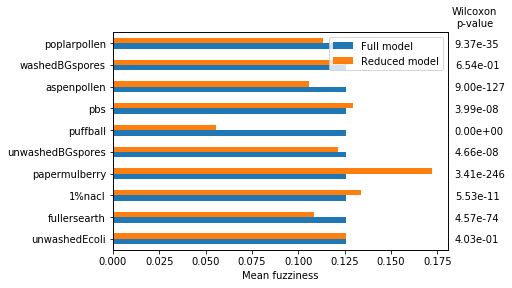

In [41]:
#
ax = stuff.drop(columns='Wilcoxon').sort_values(by='Full model').plot(kind='barh')
plt.xlabel('Mean fuzziness')

y = plt.twinx()
y.set_ylim(ax.get_ylim())
y.set_yticks(ax.get_yticks())
y.set_yticklabels(stuff.sort_values(by='Full model')['Wilcoxon'].apply(lambda x: '{:0.2e}'.format(x)))
y.tick_params(right=False)
plt.title('Wilcoxon\np-value', x=1.08, fontsize=10)

plt.show()

## Data grouping -- what can we expect the model to do with unseen particle types?

I had the idea to use hierarchical agglomerative clustering, but with an initialised clusering of the particle types, to see which types of particles were similar to each other. However, this does not seem straight-forward to do and also the dataset is quite unbalanced. Thus, I have settled for representing each particle type by mean of the samples, and using centroid linkage. In this way, the clustering should produce a result that is similar to what would have happened if the groups were of the same size (if I understand centroid linkage correctly). I also tried representing the groups by their median, just to see if it made any difference, but it was very similar.

Using other linkages (such as Ward, single, or complete) results in basically the same dendrograms as below. Using the full data (and not only averages) might give different results, but this is more of a quick-look and not really intended to be a thorough analysis anyway.

### Use HAC on class averages to see how internally consistent the broad classes are

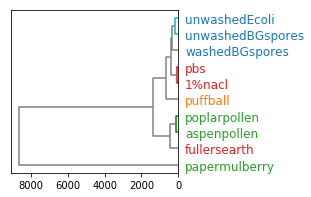

In [42]:
plt.figure(figsize=(3, 3))
df = data_train.loc[:, :].groupby(labels_train).mean()
# Calculate the distance between each sample
Z = shc.linkage(df, method='centroid')

# Make the dendrogram
dend = shc.dendrogram(Z, labels=df.index, leaf_rotation=0, orientation='left',
                      color_threshold=240, above_threshold_color='grey')

labels = plt.gca().get_ymajorticklabels()
colours = ['C2', 'C3', 'C2', 'C2', 'C1', 'C3', 'C3', 'C0', 'C0', 'C0']

for i, label in enumerate(labels):
    label.set_color(colours[i])
plt.show()

Observations:

* Unwashed BG spores are more similar to unwashed Ecoli than to washed BG spores, which suggests to me that the L-broth in the unwashed samples makes up a substantial amount of the signal. They all cluster together though, so making them one "bacteria" group is still fine.
* Paper mulberry pollen is VERY different from all the others. Grouping it with the other pollen will introduce a lot of variability to that class, but there really isn't any other group to put it in and keeping it separate is also not ideal.
* The broad groups used by Ruske et al. (2017) make sense for the most part. The exception is that fuller's earth dust is a bit different from the salt particles and that paper mulberry is very different from the other pollens.

### Look at ICP error for subclasses of pollen and bacteria

In [43]:
# Test for subclasses in pollen

effs_pol = {}

for pol in ['poplarpollen', 'aspenpollen', 'papermulberry']:
    predictions, pvalues = pvalue(model, data_test[labels_test==pol], data_cal,
                                  labels_cal.replace(broad_classes),
                                  nc_score='difference', mondrian=True)
    effs_pol[pol] = evaluate_icp(pvalues, true_labels=parentclass[labels_test==pol],
                                    sigma=np.linspace(0, 0.99, 30))

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars
/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


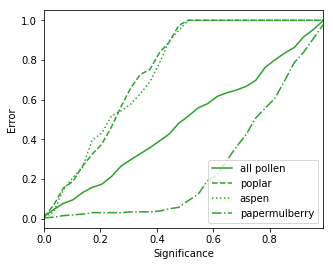

In [44]:
# Plot errors
plt.figure(figsize=(5, 4))
effs['pollen']['Error'].plot(label='all pollen', c='C2')
effs_pol['poplarpollen']['Error'].plot(label='poplar', c='C2', style='--')
effs_pol['aspenpollen']['Error'].plot(label='aspen', c='C2', style=':')
effs_pol['papermulberry']['Error'].plot(label='papermulberry', c='C2', style='-.')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Significance')
plt.show()

In [45]:
# Test for subclasses in bacteria

effs_bac = {}

for bac in ['unwashedEcoli', 'unwashedBGspores', 'washedBGspores']:
    predictions, pvalues = pvalue(model, data_test[labels_test==bac], data_cal,
                               labels_cal.replace(broad_classes),
                               nc_score='difference', mondrian=True)
    effs_bac[bac] = evaluate_icp(pvalues, true_labels=parentclass[labels_test==bac],
                                 sigma=np.linspace(0, .99, 30))

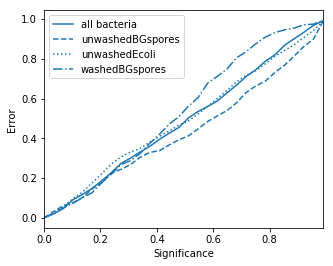

In [46]:
# Plot errors
plt.figure(figsize=(5, 4))
effs['bacteria']['Error'].plot(label='all bacteria', c='C0')
effs_bac['unwashedBGspores']['Error'].plot(label='unwashedBGspores', c='C0', style='--')
effs_bac['unwashedEcoli']['Error'].plot(label='unwashedEcoli', c='C0', style=':')
effs_bac['washedBGspores']['Error'].plot(label='washedBGspores', c='C0', style='-.')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Significance')
plt.show()

## Predict data from other MBS instrument

In [9]:
args = {'min_samples_split': 60, 'min_samples_leaf': 4,
            'max_depth': 9, 'max_features': 'sqrt',
            'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.1}

model = GradientBoostingClassifier(random_state=0, **args)

model.fit(data_train, labels_train.replace(broad_classes))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=60,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Read some data from our sea spray tank (water with sea salt and some plankton). There is a lot of data, I'll only use the first 1000 instances for a quick look at how it will be classified. It should be mostly salt, but plankton is biological material so we'll probably see some of the other classes as well. Technically some particles could contain both, and I don't know how those would be classified (that's a whole other issue...), but my supervisor tells me the plankton concentrations weren't very high so I expect mostly salt signal.

In [10]:
seaspraytank = pd.read_csv('/home/linn/Downloads/ACES_LAB_20180309_135507.csv', skiprows=33)
fullsstank = seaspraytank.copy()
seaspraytank = seaspraytank.loc[seaspraytank['FT']==0, list(stats)+fluor+['Size', 'TOF']]

In [11]:
predictions, pvalues = pvalue(model, seaspraytank.iloc[:1000], data_cal, labels_cal.replace(broad_classes),
                              nc_score='difference', mondrian=True)

In [12]:
# Instead of true classes, let's just guess that it's all salt and see what happens (I won't plot accuracies anyway)
guess = pd.Series('non-bio', index=seaspraytank.index[:1000])

output = evaluate_icp(pvalues, guess)

/home/linn/anaconda3/envs/py37env/lib/python3.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in long_scalars


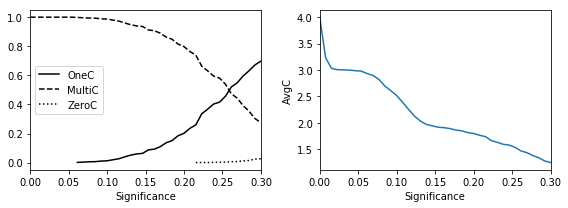

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

output[['OneC', 'MultiC', 'ZeroC']].plot(c='k', style=['-', '--', ':'], ax=ax[0])
output['AvgC'].plot(ax=ax[1])
ax[1].set_ylabel('AvgC')
ax[0].set_xlabel('Significance')
ax[1].set_xlabel('Significance')

plt.tight_layout()
plt.show()

In [14]:
pvalues.where(pvalues > 0.1).notna().sum()

bacteria    531
fungal      997
non-bio       0
pollen      988
dtype: int64

In [15]:
pvalues.where(pvalues > 0.2).notna().sum()

bacteria      0
fungal      948
non-bio       0
pollen      850
dtype: int64

* Lots of multiclass predictions and high AvgC as a result, so the model isn't very confident in its predictions
* At significance level 0.1, the ICP predicts ZERO salt particles. Seems unlikely. Our data were collected in a different way compared to Ruske, but it's surprising if it has this big of an impact! We dried our particles and Ruske did not (for salts + bacteria), so perhaps the size/shapes just didn't match up according to the model... The samples are mostly mistaken fort pollen and fungal spores, which were dry in Ruske's study as well. Further investigations needed...!